<a href="https://colab.research.google.com/github/ajinkyabhanudas/SIADS696/blob/dev/Dataset_setup_Ajinkya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook works on the first step of the train pipeline: data loading 
- The idea is to use the contents of this notebook as a makefile target so it can be the first step to run as we keep populating our datastore.








In [2]:
# !git clone https://github.com/ajinkyabhanudas/SIADS696.git

In [3]:
import datetime
import enum
import glob
import json
import os
import re
from itertools import groupby

from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore')

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
try:
  os.chdir('SIADS696')
except:
  print("You're either already in the SIADS696 directory, or the path specified isn't accessible")

### We'll extract our dataset in two parts:
- first extract the overall stats data per channel and store it along with the channel name instead of the id for available channels. (`overall_stats_raw_df`)
- And second, extract the per-video data into another dataframe. (`raw_df`)

In [6]:
rootdir = 'data'
feature_list = ['publishedAt', 'title', 'channelId', 'description',
                'channelTitle', 'tags', 'categoryId', 'viewCount', 
                'likeCount', 'favoriteCount', 'commentCount', 'duration',
                'definition', 'contentRating', 'topicCategories']

ov_dict_list = []
ov_temp_dict = {}

dict_list = []
temp_dict = {}

for path in glob.glob(f'./{rootdir}/*/*'):
  try:
    with open(path, "r") as read_file:
      data = json.load(read_file)
    for channel_id in data.keys():
      ov_temp_dict = data[channel_id]["channel_statistics"]
      channel_name = list(data[channel_id]["video_data"].keys())[0]
      ov_temp_dict["channelName"] = data[channel_id]["video_data"][channel_name]["channelTitle"]
      ov_dict_list.append(ov_temp_dict)
      
      for video_info in data[channel_id]["video_data"].values():
        temp_dict = video_info
        dict_list.append(temp_dict)       
  except:
    pass

overall_stats_raw_df = pd.DataFrame(ov_dict_list)
overall_stats_raw_df.drop("hiddenSubscriberCount", axis=1, inplace=True)

raw_df = pd.DataFrame(dict_list)
raw_df = raw_df[feature_list]

### Next, let's do a quick check on the data and take a quick look at the data in both the dfs

In [7]:
raw_df.info()
raw_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55337 entries, 0 to 55336
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   publishedAt      55337 non-null  object
 1   title            55337 non-null  object
 2   channelId        55124 non-null  object
 3   description      55124 non-null  object
 4   channelTitle     55124 non-null  object
 5   tags             51972 non-null  object
 6   categoryId       55124 non-null  object
 7   viewCount        55050 non-null  object
 8   likeCount        54589 non-null  object
 9   favoriteCount    55121 non-null  object
 10  commentCount     54549 non-null  object
 11  duration         55125 non-null  object
 12  definition       55125 non-null  object
 13  contentRating    55125 non-null  object
 14  topicCategories  54331 non-null  object
dtypes: object(15)
memory usage: 6.3+ MB


,publishedAt,title,channelId,description,channelTitle,tags,categoryId,viewCount,likeCount,favoriteCount,commentCount,duration,definition,contentRating,topicCategories
9308,2010-07-03T22:41:48Z,"Katy Perry ""California Gurls"" Parody - Califor...",UCazMm3tOCkYrIGE_17j0mVg,GET THE T-SHIRT - http://bit.ly/BartBakerShirt...,Bart Baker,"[Katy, Perry, Snoop, Dogg, California, Gurls, ...",10,57710550,213636,0,49915,PT2M30S,hd,{},"[https://en.wikipedia.org/wiki/Music, https://..."
16778,2022-08-28T18:23:39Z,A thank you and an important update,UCfZz8F37oSJ2rtcEJHM2kCg,A bit of an update\n\n⭐ SUPPORT TIK ⭐\n\nThis ...,TIKhistory,NaN,27,58092,8348,0,1193,PT7M40S,hd,{},[https://en.wikipedia.org/wiki/Lifestyle_(soci...
8873,2014-02-15T21:00:02Z,"XHIT: Legs, Bums, and Tums",UCM1Nde-9eorUhq-teaWlgUA,They're the three areas that most people are f...,XHIT Daily,"[XFit, workout routines, workout programs, wor...",17,446553,4436,0,110,PT16M55S,hd,{},[https://en.wikipedia.org/wiki/Lifestyle_(soci...
8037,2020-03-31T17:06:14Z,I Love Me - Demi Lovato | Caleb Marshall | Dan...,UCyqR7WkL8i1b6xtSssDmW9w,An easy to follow cardio dance fitness routine...,The Fitness Marshall,"[zumba, cardio hip hop, dance fitness, marshal...",26,1045299,11597,0,399,PT3M31S,hd,{},"[https://en.wikipedia.org/wiki/Hobby, https://..."
45215,2014-04-09T12:30:01Z,Are Hong Kong & Macau Countries?,UC2C_jShtL725hvbm1arSV9w,Support: https://www.patreon.com/cgpgrey\n\nSp...,CGP Grey,"[cgpgrey, education, Hong Kong (Chinese Specia...",27,5856448,93132,0,11880,PT4M53S,hd,{},[https://en.wikipedia.org/wiki/Society]


In [8]:
overall_stats_raw_df.info()
overall_stats_raw_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   viewCount        149 non-null    object
 1   subscriberCount  149 non-null    object
 2   videoCount       149 non-null    object
 3   channelName      149 non-null    object
dtypes: object(4)
memory usage: 4.8+ KB


,viewCount,subscriberCount,videoCount,channelName
135,116740581,1400000,1308,Lectures by Walter Lewin. They will make you ♥...
27,3334363850,9910000,205,Bart Baker
19,31094,10500,4,Quintessentially Viv
38,4981263404,17700000,154,Lele Pons
6,20257607432,29700000,10886,Spinnin' Records


### Let's examine our datatypes and convert them appropriately

In [9]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55337 entries, 0 to 55336
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   publishedAt      55337 non-null  object
 1   title            55337 non-null  object
 2   channelId        55124 non-null  object
 3   description      55124 non-null  object
 4   channelTitle     55124 non-null  object
 5   tags             51972 non-null  object
 6   categoryId       55124 non-null  object
 7   viewCount        55050 non-null  object
 8   likeCount        54589 non-null  object
 9   favoriteCount    55121 non-null  object
 10  commentCount     54549 non-null  object
 11  duration         55125 non-null  object
 12  definition       55125 non-null  object
 13  contentRating    55125 non-null  object
 14  topicCategories  54331 non-null  object
dtypes: object(15)
memory usage: 6.3+ MB


In [10]:
def duration_split(duration):
    try:
      for _, v in groupby(duration, str.isalpha):
        yield ''.join(v)
    except:
      yield np.nan
    
### Miles code fix included here   
def duration_2_secs(duration, duration_split=duration_split):
  temp = 0
  for i, val in enumerate(duration_split(duration)):
    
    if len(str(duration)) <= 8:
      if i==1 and not val.isalpha():
        temp += float(val)*60
      
      if i==3 and not val.isalpha():
        temp += float(val)
    else:
      if i==1 and not val.isalpha():
        temp += float(val)*60*60
      
      if i==3 and not val.isalpha():
        temp += float(val)*60
      
      if i==5 and not val.isalpha():
        temp += float(val)

  return(temp)


# duration_2_secs("PT51M12S")

In [11]:
def topic_extract(links_list):
  
  topics_list = []  
  try:
    for link in links_list:
      topics_list.append(link.split("/")[-1].lower())
    
    return(topics_list)
  except:
    pass

In [12]:
def text_prep(val):
  '''the goal is to replace the hypertexts in the 
  in any field to redundant names as vectorizing
  them could be misleading and also leak data'''

  val = str(val).lower()
  process_desc = re.sub(r'http[s]*:.*\w', 'url', val)
  process_desc = re.sub('[^a-zA-Z]', ' ', process_desc)
  process_desc = re.sub(r'\s+', ' ', process_desc)

  process_desc = nltk.sent_tokenize(process_desc)
  if not process_desc:
    process_desc = [nltk.word_tokenize(word) for word in process_desc]
  else:
    process_desc = [nltk.word_tokenize(word) for word in process_desc][0]
    
  
  word_list = [word for word in process_desc if word not in stopwords.words('english')]


  return word_list



In [13]:
text_prep("i if happening")

['happening']

In [14]:
def create_dataset(df, featureset, primary=True):

  if primary:
    df["publishedAt"] = pd.to_datetime(df.publishedAt)
    df['publishedDayNum'] = df.publishedAt.apply(lambda x: x.timetuple().tm_yday)
    df['publishedDayDelta'] = abs(df['publishedDayNum']-datetime.datetime.now().timetuple().tm_yday)
    df["categoryId"] = df.categoryId.astype(float)
    df["viewCount"] = df.viewCount.astype(float)
    df["likeCount"] = df.likeCount.astype(float)
    df["favoriteCount"] = df.favoriteCount.astype(float)
    df["commentCount"] = df.commentCount.astype(float)
    df['duration_secs'] = df.duration.apply(duration_2_secs)
    df['topicCategories'] = df.topicCategories.apply(topic_extract)
    df['tags'] = df.tags.apply(topic_extract)
    df['channelTitle'] = df.channelTitle.str.lower()
    df['description'] = df.description.apply(text_prep)
    df['title'] = df.title.apply(text_prep)
    df['len_title'] = df.title.apply(lambda x: len(x))
    df['log_duration_secs'] = np.log(df.duration_secs+1)
  
  else:
    df['ov_viewCount'] = df.viewCount.astype(float)
    df['ov_subscriberCount'] = df.subscriberCount.astype(float)
    df['ov_videoCount'] = df.videoCount.astype(float)
    df['channelName'] = df.channelName.str.lower()

  return df[featureset]

- It's best to drop tags because, in many cases, the tags tend to contain the channel names, which could as we speculated earlier, lead to data leaks.
- We'll also drop channelId because it is visually unintuitve and we can encode the channelNames with simple Id's if we needed to.
- since we don't have data in the order of millions, we'd abstract out the publishing data to a new variable of `publishedDayNum` that contains the day of the year the video was published.
- on examining `contentRating` values, the dataset in non-null but majorly contains empty dictionaries, which makes it misleading. As a result, we'll drop this feature too.
- on examining `favoriteCount` values, the dataset in non-null but majorly contains a value of `0`, which makes it misleading. As a result, we'll drop it.

- dropped columns list [`tags`, `channelId`, `contentRating`] and [`publishedAt`] after deriving the `publishedDayNum` column from it.

In [15]:
features = ['title', 'description', 'channelTitle',
 'categoryId', 'viewCount', 'likeCount',
 'commentCount', 'duration_secs', 'log_duration_secs',
 'definition', 'topicCategories', 'publishedDayNum',
 'publishedDayDelta', 'len_title']

preproc1_df = create_dataset(raw_df, features)

In [16]:
preproc1_df.sample(5)

,title,description,channelTitle,categoryId,viewCount,likeCount,commentCount,duration_secs,log_duration_secs,definition,topicCategories,publishedDayNum,publishedDayDelta,len_title
29808,"[things, christmas, dessert]","[wanting, something, different, dessert, chris...",sorted food,26.0,333324.0,7338.0,272.0,535.0,6.284134,hd,"[food, lifestyle_(sociology)]",350,72,3
17222,"[simplified, spelling, board]","[trying, spell, english, language, silent, let...",the history guy: history deserves to be rememb...,27.0,70095.0,6247.0,763.0,1028.0,6.936343,hd,[knowledge],152,126,3
38864,"[hd, foot, massage, tutorial, pain, relief, re...","[check, series, amazon, url, help, support, ch...",psychetruth,26.0,159796.0,1344.0,95.0,1811.0,7.502186,hd,"[health, lifestyle_(sociology)]",221,57,12
35510,"[almond, fettuccine, alfredo, omg]","[cheese, nuts, julie, piatt, url]",tara stiles : yoga that feels like you,26.0,5123.0,151.0,NaN,339.0,5.828946,hd,"[food, lifestyle_(sociology)]",174,104,4
23630,"[abc, news, live, fda, fully, approves, pfizer...","[plus, pentagon, officials, say, u, troops, go...",abc news,25.0,9616.0,241.0,443.0,4098.0,8.318498,hd,"[politics, society]",236,42,9


In [17]:
preproc1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55337 entries, 0 to 55336
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              55337 non-null  object 
 1   description        55337 non-null  object 
 2   channelTitle       55124 non-null  object 
 3   categoryId         55124 non-null  float64
 4   viewCount          55050 non-null  float64
 5   likeCount          54589 non-null  float64
 6   commentCount       54549 non-null  float64
 7   duration_secs      55337 non-null  float64
 8   log_duration_secs  55337 non-null  float64
 9   definition         55125 non-null  object 
 10  topicCategories    54331 non-null  object 
 11  publishedDayNum    55337 non-null  int64  
 12  publishedDayDelta  55337 non-null  int64  
 13  len_title          55337 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 5.9+ MB


Let's again take a look at what percentage of data is missing across all the fields.

In [18]:
missing_data_perc_cols = (preproc1_df.isna().sum()/len(preproc1_df))*100
missing_data_perc_cols

title                0.000000
description          0.000000
channelTitle         0.384914
categoryId           0.384914
viewCount            0.518640
likeCount            1.351718
commentCount         1.424002
duration_secs        0.000000
log_duration_secs    0.000000
definition           0.383107
topicCategories      1.817952
publishedDayNum      0.000000
publishedDayDelta    0.000000
len_title            0.000000
dtype: float64

In [19]:
lost_rows_perc = len(preproc1_df.dropna())/len(preproc1_df)*100
lost_rows_perc

96.27916222418996

It's under 5% in across all cases, which isn't a bad thing at all and we can easily consider dropping the missing fields as we would regularly keep enriching our datastore, which would easily compensate for the missing 5% over time.

In [20]:
preproc2_df = preproc1_df.dropna()

In [21]:
preproc2_df.isna().sum()

title                0
description          0
channelTitle         0
categoryId           0
viewCount            0
likeCount            0
commentCount         0
duration_secs        0
log_duration_secs    0
definition           0
topicCategories      0
publishedDayNum      0
publishedDayDelta    0
len_title            0
dtype: int64

In [22]:
preproc2_df.drop('categoryId', axis=1).describe()

,viewCount,likeCount,commentCount,duration_secs,log_duration_secs,publishedDayNum,publishedDayDelta,len_title
count,5.327800e+04,5.327800e+04,5.327800e+04,53278.000000,53278.000000,53278.000000,53278.000000,53278.000000
mean,3.158608e+06,4.917423e+04,3.022889e+03,791.403938,6.176761,182.144131,114.919648,6.011243
std,4.565088e+07,2.824296e+05,1.263771e+04,1497.323859,0.946581,103.481357,81.793264,2.538819
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000
25%,8.738600e+04,1.695000e+03,1.290000e+02,238.000000,5.476464,93.000000,44.000000,4.000000
50%,3.206290e+05,7.418000e+03,5.265000e+02,482.000000,6.180017,183.000000,95.000000,6.000000
75%,1.322312e+06,2.816250e+04,1.916000e+03,865.000000,6.763885,268.000000,185.000000,8.000000
max,5.809870e+09,3.042521e+07,1.124865e+06,42901.000000,10.666674,366.000000,277.000000,19.000000


In [23]:
preproc2_df.drop('categoryId', axis=1).corr()

,viewCount,likeCount,commentCount,duration_secs,log_duration_secs,publishedDayNum,publishedDayDelta,len_title
viewCount,1.000000,0.899907,0.721942,-0.014268,-0.026618,-0.002688,0.003995,0.001312
likeCount,0.899907,1.000000,0.845570,-0.018670,-0.026851,0.003992,-0.001212,-0.032605
commentCount,0.721942,0.845570,1.000000,-0.016090,-0.010986,0.004524,-0.001259,-0.081244
duration_secs,-0.014268,-0.018670,-0.016090,1.000000,0.602468,0.003295,-0.014514,0.114565
log_duration_secs,-0.026618,-0.026851,-0.010986,0.602468,1.000000,-0.012650,0.011645,0.112068
publishedDayNum,-0.002688,0.003992,0.004524,0.003295,-0.012650,1.000000,-0.917938,-0.003272
publishedDayDelta,0.003995,-0.001212,-0.001259,-0.014514,0.011645,-0.917938,1.000000,-0.009960
len_title,0.001312,-0.032605,-0.081244,0.114565,0.112068,-0.003272,-0.009960,1.000000


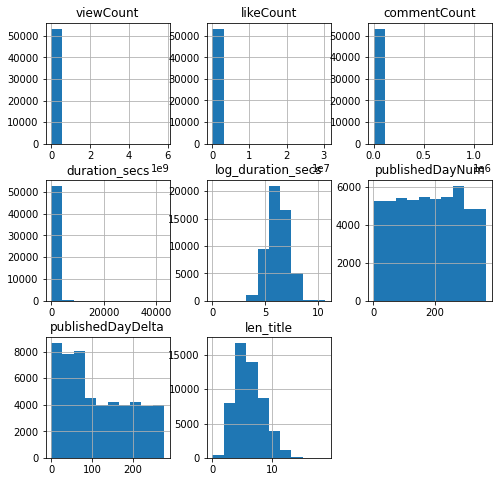

In [24]:
preproc2_df.drop('categoryId', axis=1).hist(figsize=(8,8));

We could consider applying a transformation to the data, to help address the heavy left-skew on most numerical features.

Let's quickly set the same steps up for the `overall_stats_raw_df` df.

In [25]:
overall_stats_raw_df.head()

,viewCount,subscriberCount,videoCount,channelName
0,10576768366,32900000,1141,NoCopyrightSounds
1,13637216111,55900000,403,Marshmello
2,785665015,4610000,2808,Audio Library — Music for content creators
3,24169602655,43400000,118,Katy Perry
4,12823520591,37500000,157,One Direction


In [26]:
overall_stats_raw_df.dtypes

viewCount          object
subscriberCount    object
videoCount         object
channelName        object
dtype: object

In [27]:
ov_features = ['channelName', 'ov_viewCount', 'ov_subscriberCount', 'ov_videoCount']
ov_stats_pre_df1 = create_dataset(overall_stats_raw_df, ov_features, primary=False)

In [28]:
ov_stats_pre_df1.head()

,channelName,ov_viewCount,ov_subscriberCount,ov_videoCount
0,nocopyrightsounds,1.057677e+10,32900000.0,1141.0
1,marshmello,1.363722e+10,55900000.0,403.0
2,audio library — music for content creators,7.856650e+08,4610000.0,2808.0
3,katy perry,2.416960e+10,43400000.0,118.0
4,one direction,1.282352e+10,37500000.0,157.0


In [29]:
ov_stats_pre_df1.isna().sum()

channelName           0
ov_viewCount          0
ov_subscriberCount    0
ov_videoCount         0
dtype: int64

With both the datasets ready and a basic relation overview amongst the features, we can now move onto the phase of text processing to make it machine interpretable.

In [30]:
df = pd.merge(preproc2_df, ov_stats_pre_df1, how='left', left_on='channelTitle', right_on='channelName')
df.head()

,title,description,channelTitle,categoryId,viewCount,likeCount,commentCount,duration_secs,log_duration_secs,definition,topicCategories,publishedDayNum,publishedDayDelta,len_title,channelName,ov_viewCount,ov_subscriberCount,ov_videoCount
0,"[soumix, bromar, falling, ncs, release]","[ncs, nocopyrightsounds, empowering, creators,...",nocopyrightsounds,10.0,179676.0,9313.0,698.0,130.0,4.875197,hd,"[electronic_music, hip_hop_music, music, pop_m...",270,8,5,nocopyrightsounds,1.057677e+10,32900000.0,1141.0
1,"[paul, flint, e, welem, bah, ncs, release]","[ncs, nocopyrightsounds, empowering, creators,...",nocopyrightsounds,10.0,259992.0,9364.0,691.0,156.0,5.056246,hd,"[electronic_music, hip_hop_music, music]",267,11,7,nocopyrightsounds,1.057677e+10,32900000.0,1141.0
2,"[vaance, deerock, electric, feat, robbie, rose...","[ncs, nocopyrightsounds, empowering, creators,...",nocopyrightsounds,10.0,275410.0,11977.0,707.0,180.0,5.198497,hd,"[electronic_music, music]",265,13,10,nocopyrightsounds,1.057677e+10,32900000.0,1141.0
3,"[midnight, cvlt, wiguez, feel, ncs, release]","[ncs, nocopyrightsounds, empowering, creators,...",nocopyrightsounds,10.0,273952.0,10688.0,894.0,223.0,5.411646,hd,"[electronic_music, music]",263,15,6,nocopyrightsounds,1.057677e+10,32900000.0,1141.0
4,"[arcando, ncs, release]","[ncs, nocopyrightsounds, empowering, creators,...",nocopyrightsounds,10.0,359347.0,14213.0,810.0,187.0,5.236442,hd,"[electronic_music, music]",260,18,3,nocopyrightsounds,1.057677e+10,32900000.0,1141.0


In [31]:
df['std_viewCount'] = df.groupby('channelTitle').viewCount.apply(lambda x: (x - x.mean()) / x.std()).values


In [32]:
unique_topics_list = set()
for topic_list in df.topicCategories.values:
  for topic in topic_list:
    unique_topics_list.add(topic)

unique_titles_word_list = set()
for topic_list in df.title.values:
  for topic in topic_list:
    unique_titles_word_list.add(topic)

In [33]:
# unique_titles_word_list

In [34]:
basic_model_features = ['title', 'topicCategories', 'definition', 'publishedDayNum', 'log_duration_secs', 'std_viewCount', 'publishedDayDelta', 'len_title']
basic_model_data = df[basic_model_features]

basic_model_data.head()

,title,topicCategories,definition,publishedDayNum,log_duration_secs,std_viewCount,publishedDayDelta,len_title
0,"[soumix, bromar, falling, ncs, release]","[electronic_music, hip_hop_music, music, pop_m...",hd,270,4.875197,-0.372410,8,5
1,"[paul, flint, e, welem, bah, ncs, release]","[electronic_music, hip_hop_music, music]",hd,267,5.056246,-0.370358,11,7
2,"[vaance, deerock, electric, feat, robbie, rose...","[electronic_music, music]",hd,265,5.198497,-0.369964,13,10
3,"[midnight, cvlt, wiguez, feel, ncs, release]","[electronic_music, music]",hd,263,5.411646,-0.370002,15,6
4,"[arcando, ncs, release]","[electronic_music, music]",hd,260,5.236442,-0.367820,18,3


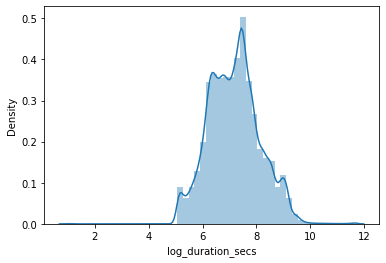

In [35]:
import seaborn as sns
#b4 transform
sns.distplot(basic_model_data.log_duration_secs+1);

In [36]:
#after transform
# sns.distplot(np.log(basic_model_data.duration_secs+1));

In [37]:
# sns.distplot(basic_model_data.publishedDayDelta);

In [38]:
word2vec_titles = Word2Vec(basic_model_data.title, min_count=1)
word2vec_topics = Word2Vec(basic_model_data.topicCategories, min_count=1)

In [39]:
# word2vec_titles.wv.vocab
word2vec_titles.wv['artificial'].shape

(100,)

In [40]:
# word2vec_titles.most_similar('travel')

In [41]:
def w2v_models(df, col_list):

  model_dict = {}
  for col in col_list:
    model_dict[col] = Word2Vec(df[col], min_count=1)
  
  return model_dict

In [42]:
w2v_model_dict = w2v_models(basic_model_data, ['title', 'topicCategories'])

In [43]:
w2v_model_dict

{'title': <gensim.models.word2vec.Word2Vec at 0x7fc46cb96d90>,
 'topicCategories': <gensim.models.word2vec.Word2Vec at 0x7fc46f256cd0>}

In [44]:
def vectorise_text(df, model):
  arr = np.zeros(100)
  for word in df:
    arr+=model.wv[word]
    
  return(np.mean(np.expand_dims(arr, axis=1), axis=1))

In [45]:
# vectorise_text(["science", "art"], w2v_model_dict['title'])
basic_model_data.columns

Index(['title', 'topicCategories', 'definition', 'publishedDayNum',
       'log_duration_secs', 'std_viewCount', 'publishedDayDelta', 'len_title'],
      dtype='object')

In [46]:
basic_model_data['vec_title'] = basic_model_data.title.apply(vectorise_text, model=w2v_model_dict['title'])
basic_model_data['vec_topicCategories'] = basic_model_data.topicCategories.apply(vectorise_text, model=w2v_model_dict['topicCategories'])

In [47]:
['title', 'topicCategories', 'definition', 'publishedDayNum', 'log_duration_secs', 'std_viewCount', 'publishedDayDelta']

['title',
 'topicCategories',
 'definition',
 'publishedDayNum',
 'log_duration_secs',
 'std_viewCount',
 'publishedDayDelta']

In [48]:
titles = pd.DataFrame(basic_model_data.vec_title.tolist(), index= basic_model_data.index, columns=["title_"+str(i) for i in range(1,101)])
topics = pd.DataFrame(basic_model_data.vec_topicCategories.tolist(), index= basic_model_data.index, columns=["topics_"+str(i) for i in range(1,101)])


In [49]:
data_df = pd.concat([titles, topics, basic_model_data[['publishedDayNum', 'log_duration_secs', 'std_viewCount', 'publishedDayDelta']], pd.get_dummies(basic_model_data.definition)], axis=1)

In [50]:
data_df.head()

,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,title_10,...,topics_97,topics_98,topics_99,topics_100,publishedDayNum,log_duration_secs,std_viewCount,publishedDayDelta,hd,sd
0,0.949307,1.225899,1.849117,-1.065505,-0.561422,-0.330514,-0.288854,1.033826,-1.668071,-1.280551,...,-0.768748,0.727406,0.598370,-0.338373,270,4.875197,-0.372410,8,1,0
1,1.781812,1.727444,3.118274,-1.687057,-0.925777,-0.762971,-0.478026,1.321976,-2.647941,-1.787900,...,-0.685646,0.510782,0.440660,-0.330562,267,5.056246,-0.370358,11,1,0
2,2.296480,2.088166,4.465529,-2.298405,-1.227891,-1.270327,-0.535123,1.583732,-3.474763,-2.107395,...,-0.551840,0.373827,0.335122,-0.297817,265,5.198497,-0.369964,13,1,0
3,0.947561,2.073876,1.898630,-1.414855,-0.876999,-0.209599,-0.363991,1.822472,-2.073148,-1.791207,...,-0.551840,0.373827,0.335122,-0.297817,263,5.411646,-0.370002,15,1,0
4,0.821876,1.094984,1.629870,-0.946244,-0.491845,-0.272588,-0.246758,0.931725,-1.480552,-1.168258,...,-0.551840,0.373827,0.335122,-0.297817,260,5.236442,-0.367820,18,1,0


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [52]:
data_train, data_test = train_test_split(data_df, test_size=0.20, random_state=42)

In [53]:
data_train["smote_thresh"] = data_train.std_viewCount>=10

In [54]:
# data_train.smote_thresh.value_counts()
data_train.head()

,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,title_10,...,topics_98,topics_99,topics_100,publishedDayNum,log_duration_secs,std_viewCount,publishedDayDelta,hd,sd,smote_thresh
7720,1.442887,3.512684,1.693536,-1.941233,-1.415235,-0.325029,-0.762872,3.130998,-2.549761,-2.678053,...,0.414646,0.578980,-0.415755,147,6.190315,-0.457201,131,1,0,False
24352,0.631267,0.547303,0.996239,-0.535727,-0.312737,-0.298199,-0.199025,0.348711,-0.792866,-0.469243,...,0.407717,0.588001,-0.405451,3,6.049733,-0.097878,275,1,0,False
17697,1.165790,0.330168,1.971176,-0.869709,-0.348145,-0.678627,-0.169968,-0.073300,-1.253723,-0.319033,...,0.250162,0.286435,-0.033649,321,6.753438,0.063920,43,1,0,False
40840,0.389812,0.323669,0.634538,-0.354450,-0.193822,-0.210895,-0.091481,0.197989,-0.499201,-0.265838,...,0.151052,0.057016,-0.046884,39,5.590987,0.605070,239,1,0,False
27694,4.740850,2.303640,4.698455,-2.244872,-1.575624,-1.314618,-1.813191,1.507265,-4.123310,-3.159736,...,0.532731,0.831475,-0.524442,1,5.765191,-0.353799,277,1,0,False


In [55]:
from imblearn.over_sampling import SMOTE 

In [56]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(data_train.drop("smote_thresh", axis=1), data_train["smote_thresh"])

In [57]:
y_res.value_counts()

False    43979
True     43979
Name: smote_thresh, dtype: int64

In [77]:
train_X = X_res.drop("std_viewCount", axis=1) #data_train.drop(["std_viewCount", "smote_thresh"], axis=1) #use X_res for smote
train_y = X_res.std_viewCount#data_train.std_viewCount

test_X = data_test.drop("std_viewCount", axis=1)
test_y = data_test.std_viewCount

In [78]:
train_X.head()

,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,title_10,...,topics_96,topics_97,topics_98,topics_99,topics_100,publishedDayNum,log_duration_secs,publishedDayDelta,hd,sd
0,1.442887,3.512684,1.693536,-1.941233,-1.415235,-0.325029,-0.762872,3.130998,-2.549761,-2.678053,...,0.193601,0.234692,0.414646,0.578980,-0.415755,147,6.190315,131,1,0
1,0.631267,0.547303,0.996239,-0.535727,-0.312737,-0.298199,-0.199025,0.348711,-0.792866,-0.469243,...,0.211600,0.229484,0.407717,0.588001,-0.405451,3,6.049733,275,1,0
2,1.165790,0.330168,1.971176,-0.869709,-0.348145,-0.678627,-0.169968,-0.073300,-1.253723,-0.319033,...,0.190153,0.235734,0.250162,0.286435,-0.033649,321,6.753438,43,1,0
3,0.389812,0.323669,0.634538,-0.354450,-0.193822,-0.210895,-0.091481,0.197989,-0.499201,-0.265838,...,0.015843,0.083458,0.151052,0.057016,-0.046884,39,5.590987,239,1,0
4,4.740850,2.303640,4.698455,-2.244872,-1.575624,-1.314618,-1.813191,1.507265,-4.123310,-3.159736,...,0.326001,0.321317,0.532731,0.831475,-0.524442,1,5.765191,277,1,0


In [79]:
# set(X_res.columns)-set(test_X.columns)

In [80]:
# train_X

In [150]:
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)



In [82]:
pca = PCA(n_components=20)
pca.fit(train_X)
# print(()))

PCA(n_components=20)

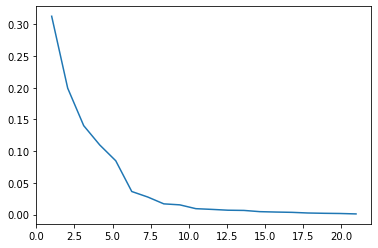

In [83]:
import matplotlib.pyplot as plt
##SCREE PLOT
plt.plot(np.linspace(1,21,20),pca.explained_variance_ratio_);

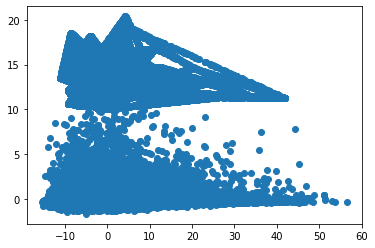

In [84]:
pca = PCA(n_components=5) #components based on the scree plot above

pca_train_X = pca.fit_transform(train_X)

plt.scatter(pca_train_X[:,0], train_y);

based on the first PCA, it is clear that the data is not linear and we would have to bear that in mind with the choice of our models

In [85]:
pca_train_X.shape, train_y.shape

((87958, 5), (87958,))

In [86]:
pca = PCA(n_components=5) #components based on the scree plot above

pca_train_X = pca.fit_transform(train_X)
pca_test_X = pca.transform(test_X)


In [87]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


In [88]:
# train_X=pca_train_X
# test_X=pca_test_X

In [93]:
# data_train.sample(frac=0.2,replace=True)

In [89]:
# poly = PolynomialFeatures(5)
# x_poly_train = poly.fit_transform(train_X)
# x_poly_test = poly.transform(test_X)

# train_X = x_poly_train
# test_X = x_poly_test ###uncomment 3 cells above for another test

In [151]:
lr = LinearRegression(fit_intercept=False)
llr = Lasso(alpha=0.1)
rr = Ridge(alpha=1.0)
dr = DummyRegressor(strategy="mean")
svr = SVR(kernel = 'linear')
dtr = DecisionTreeRegressor(max_depth=10)

lr.fit(train_X, train_y)
llr.fit(train_X, train_y)
rr.fit(train_X, train_y)
dr.fit(train_X, train_y)
# svr.fit(train_X, train_y)
dtr.fit(train_X, train_y)

DecisionTreeRegressor(max_depth=10)

In [153]:
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout

def build_sequential():
  model = Sequential([
    Dense(10, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(20, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(30, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(60, kernel_initializer='normal', activation='relu'),
    Dropout(0.1),
    Dense(15, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model
# build the model
model = build_sequential()

In [154]:
model.compile(
    loss="mean_absolute_error", 
    optimizer=Adam(), 
    metrics=["mean_absolute_error"]
)

In [155]:
history = model.fit(
    train_X, 
    train_y,
    epochs=20, 
    batch_size=128,
    validation_split=0.2
)

Epoch 1/20
550/550 [==============================] - 2s 3ms/step - loss: 4.0585 - mean_absolute_error: 4.0585 - val_loss: 5.7947 - val_mean_absolute_error: 5.7947
Epoch 2/20
550/550 [==============================] - 1s 3ms/step - loss: 3.2045 - mean_absolute_error: 3.2045 - val_loss: 5.5473 - val_mean_absolute_error: 5.5473
Epoch 3/20
550/550 [==============================] - 2s 3ms/step - loss: 3.0650 - mean_absolute_error: 3.0650 - val_loss: 5.0542 - val_mean_absolute_error: 5.0542
Epoch 4/20
550/550 [==============================] - 1s 3ms/step - loss: 2.9997 - mean_absolute_error: 2.9997 - val_loss: 5.4092 - val_mean_absolute_error: 5.4092
Epoch 5/20
550/550 [==============================] - 2s 3ms/step - loss: 2.9167 - mean_absolute_error: 2.9167 - val_loss: 5.2406 - val_mean_absolute_error: 5.2406
Epoch 6/20
550/550 [==============================] - 1s 3ms/step - loss: 2.9015 - mean_absolute_error: 2.9015 - val_loss: 5.3375 - val_mean_absolute_error: 5.3375
Epoch 7/20
550/5

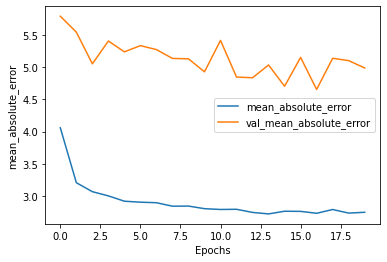

In [156]:
def plot_history(history, type_err):
  plt.plot(history.history[type_err])
  plt.plot(history.history['val_'+type_err])
  plt.xlabel("Epochs")
  plt.ylabel(type_err)
  plt.legend([type_err, 'val_'+type_err])
  plt.show()

plot_history(history, 'mean_absolute_error')

In [157]:
lr.score(train_X, train_y)
# cross_val_score(dtr, train_X, train_y, cv=5)

-0.5429264216879273

In [158]:
lr_pred = lr.predict(test_X)
dr_pred = dr.predict(test_X)
rr_pred = rr.predict(test_X)
# svr_pred = svr.predict(test_X)
dtr_pred = dtr.predict(test_X)
llr_pred = llr.predict(test_X)
nn_pred = model.predict(test_X)

In [159]:
def ret_metrics(test_y, pred):

  mae = metrics.mean_absolute_error(test_y, pred)
  mse = metrics.mean_squared_error(test_y, pred)
  rmse = np.sqrt(mse)

  return(mae, mse, rmse)

In [160]:
print(f"LR metrics for mae, mse, rmse are: {ret_metrics(test_y, lr_pred)}")
print(f"LLR metrics for mae, mse, rmse are: {ret_metrics(test_y, llr_pred)}")
print(f"DR metrics for mae, mse, rmse are: {ret_metrics(test_y, dr_pred)}")
print(f"RR metrics for mae, mse, rmse are: {ret_metrics(test_y, rr_pred)}")
# print(f"SVR metrics for mae, mse, rmse are: {ret_metrics(test_y, svr_pred)}")
print(f"DTR metrics for mae, mse, rmse are: {ret_metrics(test_y, dtr_pred)}")
print(f"NN metrics for mae, mse, rmse are: {ret_metrics(test_y, nn_pred)}")


LR metrics for mae, mse, rmse are: (3.2770622403542027, 29.239656200763033, 5.407370544059565)
LLR metrics for mae, mse, rmse are: (5.849788465227323, 37.32360078568383, 6.109304443689464)
DR metrics for mae, mse, rmse are: (6.5283600924012255, 43.30980231317515, 6.581018334055539)
RR metrics for mae, mse, rmse are: (4.5380580802463415, 30.029579213393657, 5.479925110199377)
DTR metrics for mae, mse, rmse are: (3.2068711524073823, 24.048594314072172, 4.903936613994126)
NN metrics for mae, mse, rmse are: (1.1459228873674712, 9.41691503737436, 3.0686992419222774)


In [161]:
preds_df = pd.DataFrame({"true":test_y, "lr":lr_pred, "dr":dr_pred, "rr":rr_pred, "svr":-1, "dtr":dtr_pred, "llr":llr_pred, "nn": nn_pred[:,0]})

In [162]:
preds_df

,true,lr,dr,rr,svr,dtr,llr,nn
4503,0.783847,-4.713959,6.507242,0.993412,-1,-0.057930,1.092039,-0.196818
4251,-0.237004,-4.694113,6.507242,2.002563,-1,3.336954,3.692670,-0.197186
45432,-0.216424,-3.799868,6.507242,2.529808,-1,-0.017896,4.952902,-0.196491
14495,3.040152,-5.136452,6.507242,1.440489,-1,-0.093706,5.670312,-0.198637
32005,-0.393690,-0.811090,6.507242,5.829602,-1,2.473384,6.337955,-0.097743
...,...,...,...,...,...,...,...,...
19136,0.613332,-5.212486,6.507242,1.180350,-1,2.473384,5.692717,-0.197793
626,-0.203508,-4.458524,6.507242,2.804407,-1,-0.051843,7.080667,-0.195694
51113,2.659865,-6.118617,6.507242,1.150614,-1,5.019865,6.223894,-0.198830
32042,-0.399667,-2.637467,6.507242,3.840974,-1,3.336954,6.235729,-0.190260


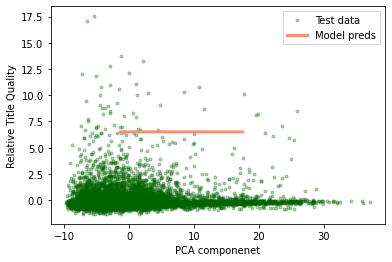

In [169]:
lists = sorted(zip(*[test_y, dr_pred]))
sorted_x_test, sorted_y_test_pred = list(zip(*lists))
pca_n = 1


# plt.plot(pca_train_X[:,pca_n],train_y,'.',color="darkblue", alpha=0.3,label="Train data")
plt.plot(pca_test_X[:,pca_n],test_y,'.',color='darkgreen', alpha=0.3, label="Test data")
plt.ylabel('Relative Title Quality')
plt.xlabel('PCA componenet')

plt.plot(sorted_x_test,sorted_y_test_pred,color='#FD8E70',linewidth=3, label="Model preds")

plt.legend()
plt.show()